# Child Malnutrition Prediction using Logistic Regression

## Project Overview
This notebook implements a **Logistic Regression** model to classify child malnutrition status into three categories:
- **OK**: Normal nutritional status
- **Borderline**: At risk of malnutrition
- **Malnourished**: Confirmed malnutrition

### Features Used:
- Anthropometric measurements: age, sex, height, weight, MUAC, head circumference
- Socio-economic factors: birth weight, meals per day, household income, family type
- Derived features: weight-for-age z-score

---

In [41]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score,
                             precision_score, recall_score, f1_score, roc_auc_score,
                             roc_curve, auc)
from sklearn.preprocessing import label_binarize
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

---
## 1. Data Loading and Exploration
---

In [42]:
# Load the dataset
# Replace 'your_dataset.csv' with your actual dataset file
df = pd.read_csv('data/synthetic_malnutrition_12000.csv')

print(f"Dataset Shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
df.head()

Dataset Shape: (12000, 13)
Columns: ['id', 'age_years', 'sex', 'height_cm', 'weight_kg', 'MUAC_cm', 'head_circumference_cm', 'birth_weight_kg', 'meals_per_day', 'household_income_inr', 'type_of_family', 'weight_for_age_z_like', 'label']


,id,age_years,sex,height_cm,weight_kg,MUAC_cm,head_circumference_cm,birth_weight_kg,meals_per_day,household_income_inr,type_of_family,weight_for_age_z_like,label
0,1,1.77,Female,85.1,11.32,18.0,47.6,2.52,6,45964.36,Joint,-0.31,OK
1,2,1.24,Male,75.8,8.97,16.8,47.6,3.51,4,11867.24,Nuclear,-0.90,OK
2,3,2.08,Female,87.9,13.66,20.8,47.4,2.81,4,4362.64,Nuclear,0.46,OK
3,4,0.80,Female,72.6,9.88,18.0,42.2,2.83,7,27964.67,Nuclear,0.72,OK
4,5,2.75,Female,94.4,15.58,22.0,48.2,3.08,3,4813.53,Nuclear,0.45,OK


In [43]:
# Basic dataset information
print("Dataset Info:")
df.info()
print("" + "="*50)
print("Basic Statistics:")
df.describe()

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     12000 non-null  int64  
 1   age_years              12000 non-null  float64
 2   sex                    12000 non-null  object 
 3   height_cm              12000 non-null  float64
 4   weight_kg              12000 non-null  float64
 5   MUAC_cm                12000 non-null  float64
 6   head_circumference_cm  12000 non-null  float64
 7   birth_weight_kg        12000 non-null  float64
 8   meals_per_day          12000 non-null  int64  
 9   household_income_inr   12000 non-null  float64
 10  type_of_family         12000 non-null  object 
 11  weight_for_age_z_like  12000 non-null  float64
 12  label                  12000 non-null  object 
dtypes: float64(8), int64(2), object(3)
memory usage: 1.2+ MB
Basic Statistics:


,id,age_years,height_cm,weight_kg,MUAC_cm,head_circumference_cm,birth_weight_kg,meals_per_day,household_income_inr,weight_for_age_z_like
count,12000.00000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000
mean,6000.50000,4.248456,96.992208,18.619840,19.537083,47.806775,2.997426,4.299417,22522.657478,0.005656
std,3464.24595,3.731197,26.283627,10.874292,2.941478,4.001619,0.448680,1.466724,24122.909317,0.719999
min,1.00000,0.000000,45.900000,1.500000,9.000000,33.600000,1.330000,2.000000,2000.000000,-2.730000
25%,3000.75000,1.160000,76.700000,10.100000,17.500000,45.900000,2.690000,3.000000,8206.560000,-0.480000
50%,6000.50000,2.220000,88.800000,13.485000,20.800000,48.200000,3.000000,4.000000,15213.020000,0.010000
75%,9000.25000,7.560000,120.700000,28.120000,22.000000,50.700000,3.300000,5.000000,27272.567500,0.490000
max,12000.00000,12.000000,154.700000,46.660000,22.000000,58.100000,4.690000,8.000000,200000.000000,2.880000


In [44]:
# Check class distribution
print("Label Distribution:")
print(df['label'].value_counts())
print("Label Distribution (%):")
print(df['label'].value_counts(normalize=True) * 100)

Label Distribution:
label
OK              11568
Borderline        294
Malnourished      138
Name: count, dtype: int64
Label Distribution (%):
label
OK              96.40
Borderline       2.45
Malnourished     1.15
Name: proportion, dtype: float64


In [45]:
# Check for missing values
print("Missing Values:")
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])

if missing_values.sum() == 0:
    print("No missing values found!")

Missing Values:
Series([], dtype: int64)
No missing values found!


---
## 2. Data Preprocessing
---

In [46]:
# Create a copy of the dataframe
df_processed = df.copy()

# Drop ID column as it's not a feature
if 'id' in df_processed.columns:
    df_processed = df_processed.drop('id', axis=1)

print("Processed dataset shape:", df_processed.shape)

Processed dataset shape: (12000, 12)


In [ ]:
# Handle categorical variables
label_encoders = {}

categorical_cols = ['sex', 'type_of_family']
for col in categorical_cols:
    if col in df_processed.columns:
        le = LabelEncoder()
        df_processed[col] = le.fit_transform(df_processed[col].astype(str))
        label_encoders[col] = le
        print(f"{col} encoded: {dict(zip(le.classes_, le.transform(le.classes_)))}")

print("Categorical encoding completed!")

sex encoded: {'Female': 0, 'Male': 1}
type_of_family encoded: {'Extended': 0, 'Joint': 1, 'Nuclear': 2, 'Single parent': 3}
Categorical encoding completed!


In [48]:
# Separate features and target
X = df_processed.drop('label', axis=1)
y = df_processed['label']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Feature columns: {X.columns.tolist()}")

Features shape: (12000, 11)
Target shape: (12000,)
Feature columns: ['age_years', 'sex', 'height_cm', 'weight_kg', 'MUAC_cm', 'head_circumference_cm', 'birth_weight_kg', 'meals_per_day', 'household_income_inr', 'type_of_family', 'weight_for_age_z_like']


In [49]:
# Split the data into training and testing sets (70-30 split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")
print(f"Training set label distribution:{y_train.value_counts()}")
print(f"Testing set label distribution:{y_test.value_counts()}")

Training set size: 8400 samples
Testing set size: 3600 samples
Training set label distribution:label
OK              8097
Borderline       206
Malnourished      97
Name: count, dtype: int64
Testing set label distribution:label
OK              3471
Borderline        88
Malnourished      41
Name: count, dtype: int64


In [50]:
# Feature Scaling - Standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Feature scaling completed!")
print(f"Mean of scaled training features (should be ~0):{X_train_scaled.mean(axis=0)}")
print(f"Std of scaled training features (should be ~1):{X_train_scaled.std(axis=0)}")

Feature scaling completed!
Mean of scaled training features (should be ~0):[ 2.93944763e-17 -7.73984051e-17  3.39833981e-16  4.16597973e-17
 -1.29018489e-15 -5.36713531e-16 -5.04569931e-16  1.48029737e-16
 -1.81865105e-17  9.89684525e-17 -9.30472630e-18]
Std of scaled training features (should be ~1):[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


---
## 3. Model Training - Logistic Regression
---

In [51]:
# Initialize Logistic Regression model
# For multiclass classification, use 'multinomial' solver
log_reg = LogisticRegression(
    multi_class='multinomial',
    solver='lbfgs',
    max_iter=1000,
    random_state=42,
    class_weight='balanced'  # Handle class imbalance
)

print("Logistic Regression Model Initialized")
print(f"Parameters: {log_reg.get_params()}")

Logistic Regression Model Initialized
Parameters: {'C': 1.0, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 1000, 'multi_class': 'multinomial', 'n_jobs': None, 'penalty': 'l2', 'random_state': 42, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


In [52]:
# Train the model
print("Training the model...")
log_reg.fit(X_train_scaled, y_train)
print("Training completed!")

Training the model...


Training completed!


In [53]:
# Cross-validation on training data
cv_scores = cross_val_score(
    log_reg, X_train_scaled, y_train, 
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='accuracy'
)

print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

Cross-Validation Scores: [0.81904762 0.79821429 0.80357143 0.82321429 0.8172619 ]
Mean CV Accuracy: 0.8123 (+/- 0.0096)


---
## 4. Model Evaluation
---

In [54]:
# Make predictions
y_train_pred = log_reg.predict(X_train_scaled)
y_test_pred = log_reg.predict(X_test_scaled)

# Get probability predictions for ROC-AUC
y_train_proba = log_reg.predict_proba(X_train_scaled)
y_test_proba = log_reg.predict_proba(X_test_scaled)

print("Predictions completed!")

Predictions completed!


In [55]:
# Calculate evaluation metrics
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print("="*60)
print("LOGISTIC REGRESSION MODEL PERFORMANCE")
print("="*60)
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Testing Accuracy: {test_accuracy:.4f}")
print(f"Accuracy Difference (Overfitting Check): {abs(train_accuracy - test_accuracy):.4f}")

LOGISTIC REGRESSION MODEL PERFORMANCE
Training Accuracy: 0.8143
Testing Accuracy: 0.8253
Accuracy Difference (Overfitting Check): 0.0110


In [56]:
# Detailed classification report
print("" + "="*60)
print("CLASSIFICATION REPORT - TEST SET")
print("="*60)
print(classification_report(y_test, y_test_pred))

CLASSIFICATION REPORT - TEST SET


              precision    recall  f1-score   support

  Borderline       0.05      0.28      0.09        88
Malnourished       0.16      0.68      0.25        41
          OK       0.99      0.84      0.91      3471

    accuracy                           0.83      3600
   macro avg       0.40      0.60      0.42      3600
weighted avg       0.96      0.83      0.88      3600



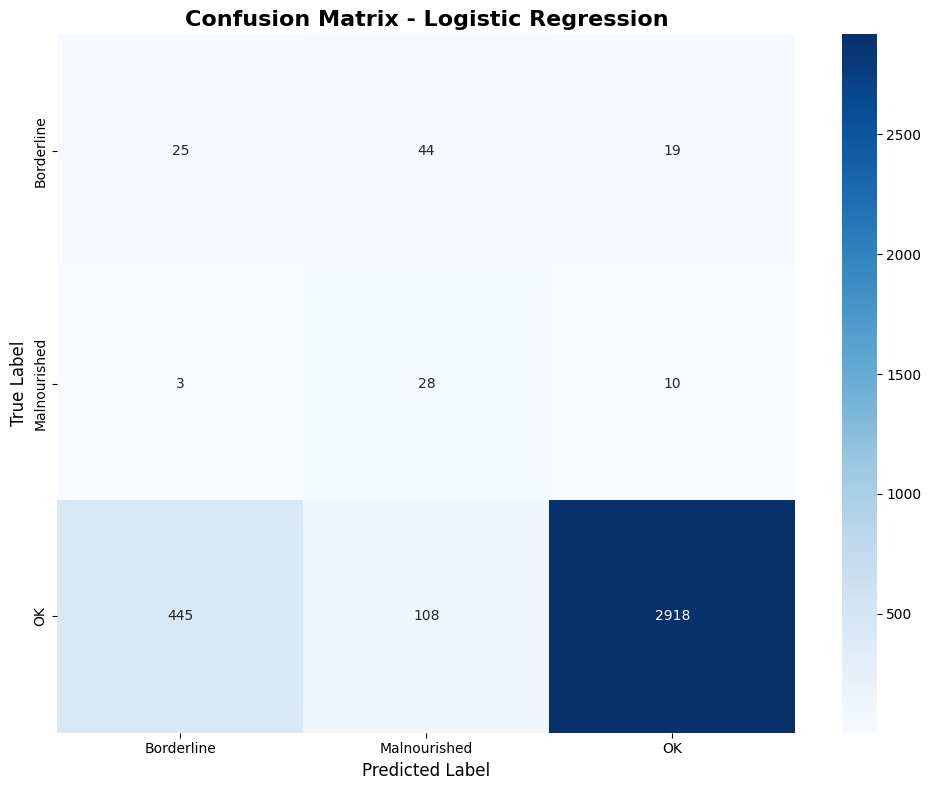

Confusion Matrix saved as 'logreg_confusion_matrix.png'


In [57]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=log_reg.classes_, yticklabels=log_reg.classes_)
plt.title('Confusion Matrix - Logistic Regression', fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.savefig('logreg_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("Confusion Matrix saved as 'logreg_confusion_matrix.png'")

In [58]:
# Calculate and display precision, recall, F1-score for each class
precision = precision_score(y_test, y_test_pred, average=None)
recall = recall_score(y_test, y_test_pred, average=None)
f1 = f1_score(y_test, y_test_pred, average=None)

metrics_df = pd.DataFrame({
    'Class': log_reg.classes_,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1
})

print("Per-Class Metrics:")
print(metrics_df.to_string(index=False))

Per-Class Metrics:
       Class  Precision   Recall  F1-Score
  Borderline   0.052854 0.284091  0.089127
Malnourished   0.155556 0.682927  0.253394
          OK   0.990159 0.840680  0.909318


In [59]:
# ROC-AUC Score (One-vs-Rest for multiclass)
y_test_binarized = label_binarize(y_test, classes=log_reg.classes_)

# Calculate ROC-AUC for each class
roc_auc_dict = {}
for i, class_name in enumerate(log_reg.classes_):
    roc_auc_dict[class_name] = roc_auc_score(y_test_binarized[:, i], y_test_proba[:, i])

# Macro and weighted average
macro_roc_auc = roc_auc_score(y_test_binarized, y_test_proba, average='macro', multi_class='ovr')
weighted_roc_auc = roc_auc_score(y_test_binarized, y_test_proba, average='weighted', multi_class='ovr')

print("" + "="*60)
print("ROC-AUC SCORES")
print("="*60)
for class_name, score in roc_auc_dict.items():
    print(f"{class_name}: {score:.4f}")
print(f"Macro Average ROC-AUC: {macro_roc_auc:.4f}")
print(f"Weighted Average ROC-AUC: {weighted_roc_auc:.4f}")

ROC-AUC SCORES
Borderline: 0.7687
Malnourished: 0.8343
OK: 0.8450
Macro Average ROC-AUC: 0.8160
Weighted Average ROC-AUC: 0.8430


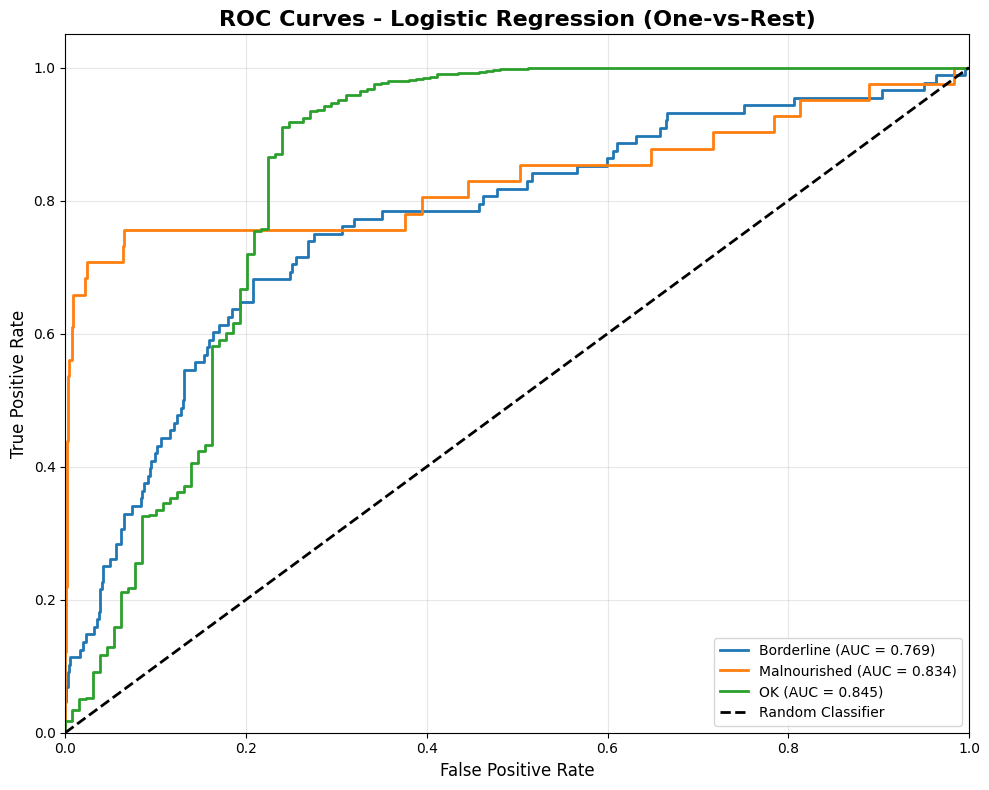

ROC curves saved as 'logreg_roc_curves.png'


In [60]:
# Plot ROC curves for each class
plt.figure(figsize=(10, 8))

for i, class_name in enumerate(log_reg.classes_):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_test_proba[:, i])
    roc_auc = roc_auc_dict[class_name]
    plt.plot(fpr, tpr, lw=2, 
             label=f'{class_name} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression (One-vs-Rest)', fontsize=16, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('logreg_roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print("ROC curves saved as 'logreg_roc_curves.png'")

---
## 5. Feature Importance Analysis
---

In [61]:
# Get feature coefficients
# For multiclass, coefficients are available for each class
coefficients = log_reg.coef_
feature_names = X.columns

# Calculate average absolute coefficients across all classes
avg_abs_coef = np.abs(coefficients).mean(axis=0)

# Create dataframe for visualization
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': avg_abs_coef
}).sort_values('Importance', ascending=False)

print("Feature Importance (Average Absolute Coefficients):")
print(feature_importance_df.to_string(index=False))

Feature Importance (Average Absolute Coefficients):
              Feature  Importance
            weight_kg    1.752296
            age_years    1.620190
              MUAC_cm    0.466899
            height_cm    0.166484
head_circumference_cm    0.126970
weight_for_age_z_like    0.086078
 household_income_inr    0.063378
                  sex    0.049325
       type_of_family    0.034776
      birth_weight_kg    0.029148
        meals_per_day    0.022093


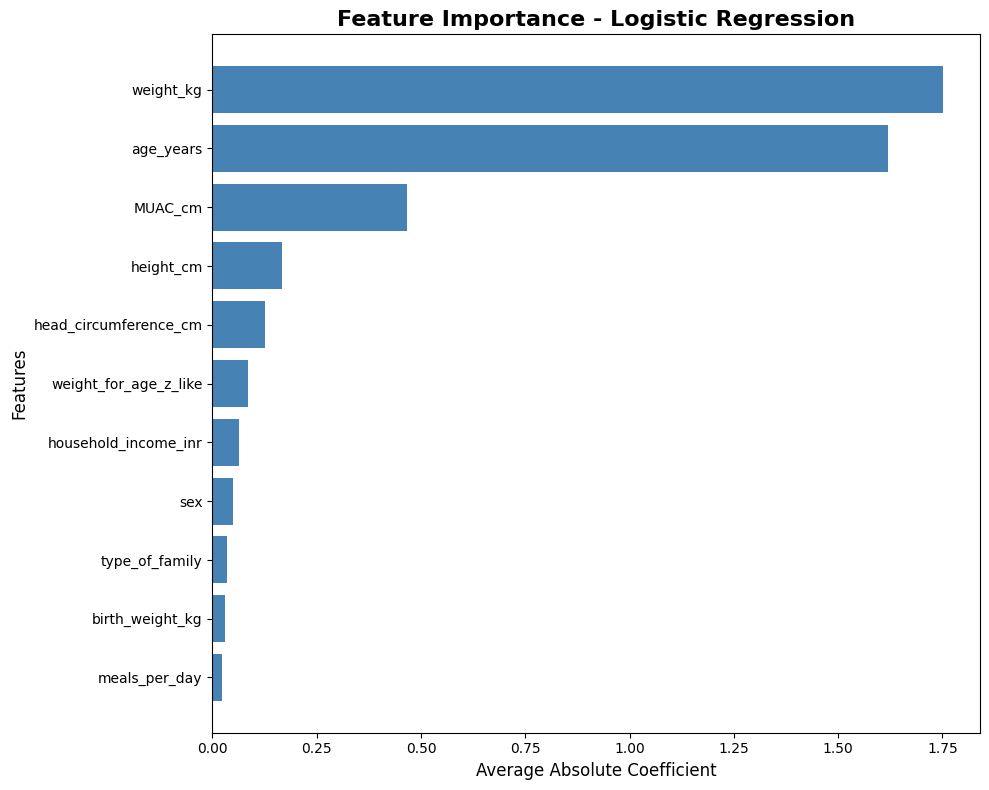

Feature importance plot saved as 'logreg_feature_importance.png'


In [62]:
# Plot feature importance
plt.figure(figsize=(10, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='steelblue')
plt.xlabel('Average Absolute Coefficient', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title('Feature Importance - Logistic Regression', fontsize=16, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('logreg_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print("Feature importance plot saved as 'logreg_feature_importance.png'")

---
## 6. Model Summary & Export
---

In [63]:
# Save the model
import joblib

joblib.dump(log_reg, 'logistic_regression_model.pkl')
joblib.dump(scaler, 'scaler_logreg.pkl')
joblib.dump(label_encoders, 'label_encoders_logreg.pkl')

print("Model saved successfully!")
print("Files created:")
print("  - logistic_regression_model.pkl")
print("  - scaler_logreg.pkl")
print("  - label_encoders_logreg.pkl")

Model saved successfully!
Files created:
  - logistic_regression_model.pkl
  - scaler_logreg.pkl
  - label_encoders_logreg.pkl


In [64]:
# Final Summary
print("" + "="*70)
print(" "*15 + "LOGISTIC REGRESSION MODEL SUMMARY")
print("="*70)
print(f"Dataset Size: {len(df)} samples")
print(f"Number of Features: {X.shape[1]}")
print(f"Number of Classes: {len(log_reg.classes_)}")
print(f"Classes: {log_reg.classes_}")
print(f"Training Set: {len(X_train)} samples ({len(X_train)/len(df)*100:.1f}%)")
print(f"Testing Set: {len(X_test)} samples ({len(X_test)/len(df)*100:.1f}%)")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Macro Average ROC-AUC: {macro_roc_auc:.4f}")
print(f"Weighted Average ROC-AUC: {weighted_roc_auc:.4f}")
print(f"Mean Cross-Validation Score: {cv_scores.mean():.4f}")
print("" + "="*70)
print("Top 5 Most Important Features:")
print(feature_importance_df.head().to_string(index=False))
print("" + "="*70)

               LOGISTIC REGRESSION MODEL SUMMARY
Dataset Size: 12000 samples
Number of Features: 11
Number of Classes: 3
Classes: ['Borderline' 'Malnourished' 'OK']
Training Set: 8400 samples (70.0%)
Testing Set: 3600 samples (30.0%)
Test Accuracy: 0.8253
Macro Average ROC-AUC: 0.8160
Weighted Average ROC-AUC: 0.8430
Mean Cross-Validation Score: 0.8123
Top 5 Most Important Features:
              Feature  Importance
            weight_kg    1.752296
            age_years    1.620190
              MUAC_cm    0.466899
            height_cm    0.166484
head_circumference_cm    0.126970


In [ ]:
# Accuracy, Precision, Recall and F1-Score
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred, average='weighted')
recall = recall_score(y_test, y_test_pred, average='weighted')
f1 = f1_score(y_test, y_test_pred, average='weighted')
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')

Accuracy: 0.8253
Precision: 0.9577
Recall: 0.8253
F1-Score: 0.8818
